# Percepção Computacional - Gunshot Audio Dataset

Dataset: [Gunshot Audio Dataset](https://www.kaggle.com/datasets/emrahaydemr/gunshot-audio-dataset)

**Antes de rodar a célula de download:** configure as credenciais do Kaggle (uma vez por máquina).

1. Em [Kaggle → Account → API](https://www.kaggle.com/settings), clique em "Create Legacy API Key" que será baixado um kaggle.json, mova-o para esse diretório (Existe um kaggle.exemple.json com o formato desejado). Configure também o .env usando como referência o .env.exemple



## Apresentação do trabalho

Alunos:

- Orlando - 122210927
- Vinícius Ian - 122210392
- Jhonata - 122210145
- Everton Kauan - 122210386
- Gabriel Dantas - 121110669

Este notebook investiga uma abordagem de **classificação de áudio de armas** com base no som dos disparos.

A estratégia adotada é converter os sinais em **mel-espectrogramas** e usar uma **rede neural convolucional (CNN)** para aprender padrões discriminativos entre as classes de armamento.

## Sobre o Dataset

O **Gunshot Audio Dataset**, disponibilizado por Emrah Aydemir no Kaggle, é uma coleção de áudios de disparos de armas de fogo compilados a partir de vídeos de domínio público no YouTube. O conjunto de dados foi estruturado especificamente para tarefas de reconhecimento de padrões e classificação de áudio em contextos de perícia digital e segurança.

As principais características do dataset incluem:

* **Composição:** Contém um total de 751 amostras de áudio distribuídas em 8 classes de armamentos distintos, como **AK-47**, **M16**, **IMI Desert Eagle**, **MP5**, **AK-12**, **M249**, **MG-42** e **Zastava M92**.
* **Especificações Técnicas:** Os arquivos estão no formato `.wav`, com uma taxa de amostragem de **44.100 Hz**. Cada clipe de áudio possui uma duração padronizada de **2 segundos**, focando no sinal acústico do disparo.
* **Qualidade dos Dados:** Durante a curadoria, os áudios foram editados e filtrados para remover ruídos de fundo significativos e garantir que os segmentos capturassem as características discriminativas de cada modelo de arma.

Este dataset é particularmente adequado para o treinamento de Redes Neurais Convolucionais (CNNs), pois a curta duração e a padronização das amostras facilitam a conversão dos sinais para representações visuais, como os **mel-espectrogramas**, permitindo que o modelo aprenda as assinaturas sonoras únicas de cada tipo de disparo.

## Imports e Preparação do ambiente

In [14]:
from kaggle.api.kaggle_api_extended import KaggleApi
import json
import os
from pathlib import Path
import librosa
from tqdm import tqdm
from IPython.display import Audio, display

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers


## Carregar os dados usando a API do Kaggle

In [8]:

raiz = Path(".").resolve()
with open(raiz / "kaggle.json", encoding="utf-8") as f:
    cred = json.load(f)
os.environ["KAGGLE_USERNAME"] = cred["username"]
os.environ["KAGGLE_KEY"] = cred["key"]



Cria a pasta e faz o download dos audios

In [9]:
api = KaggleApi()
api.authenticate()

path = Path("data")
path.mkdir(exist_ok=True)

api.dataset_download_files(
    "emrahaydemr/gunshot-audio-dataset",
    path=str(path),
    unzip=True,
)
print("Dataset baixado em:", path.resolve())

Dataset URL: https://www.kaggle.com/datasets/emrahaydemr/gunshot-audio-dataset
Dataset baixado em: C:\percepcao\percepcao-computacional\data


## Análise Exploratória de Dados

Foi realizada uma análise exploratória para entender o comportamento acústico inicial do dataset antes do treinamento.

Nesta parte, observamos exemplos de diferentes armas no domínio do tempo e da frequência, permitindo verificar variações de intensidade, conteúdo espectral e possíveis semelhanças entre classes.

Exemplo de código pegando o segundo exemplo de cada base

In [4]:
data_dir = Path('./data')
lista_exemplos = []

for pasta in data_dir.iterdir():
    if pasta.is_dir():

        arquivos = list(pasta.glob('*.wav'))

        if arquivos:
            lista_exemplos.append(arquivos[1])
num_arquivos = len(lista_exemplos)

num_arquivos, lista_exemplos


(8,
 [PosixPath('data/MP5/8 (2).wav'),
  PosixPath('data/Zastava M92/9 (34).wav'),
  PosixPath('data/IMI Desert Eagle/2 (5).wav'),
  PosixPath('data/AK-47/1 (43).wav'),
  PosixPath('data/AK-12/3 (13).wav'),
  PosixPath('data/M249/6 (68).wav'),
  PosixPath('data/M16/5 (99).wav'),
  PosixPath('data/MG-42/7 (10).wav')])

Exemplo de um áudio da base

In [5]:

file = './data/AK-47/1 (10).wav'
Audio(filename=file)

## Processamento de Áudio com Librosa

Nesta etapa, carregamos o arquivo de áudio para transformá-lo em dados numéricos que o computador consiga processar. O resultado exibido representa três informações fundamentais:

- 96.000 (Número de Amostras): É o comprimento total do vetor de dados. Indica quantos "pontos" de informação foram extraídos do arquivo.

- 48.000 (Taxa de Amostragem): Indica que o som foi capturado 48.000 vezes por segundo (48 kHz). Como o áudio tem 96.000 amostras totais, sabemos que ele dura exatamente 2 segundos ($96.000 / 48.000 = 2$).

- Array de Amplitudes: São os valores numéricos que representam a vibração do som. O Librosa normaliza esses valores entre -1.0 e 1.0, onde 0 é o silêncio total.

In [6]:
# Carrega o áudio mantendo a taxa original (sr=None) e convertendo para um único canal (mono).
# sample_test: Array com a amplitude do som (o 'desenho' da onda).
# sr_test: Taxa de amostragem (quantas vezes por segundo o som foi medido).
# O output mostra: (Total de amostras, Frequência em Hz, Vetor de dados).
sample_test, sr_test = librosa.load(file, sr=None, mono=True)

len(sample_test), sr_test, sample_test

/home/orlandojunior/miniconda3/envs/percepcao/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(96000,
 48000,
 array([ 0.00215149, -0.0380249 ,  0.06178284, ..., -0.11155701,
        -0.139328  , -0.11264038], dtype=float32))

## Funções para plotar os gráficos

O código abaixo declara as funções para plotagem de gráficos da **amplitude x tempo** e **Espectro de Frequência** de cada item da lista *lista_exemplos*

Link do site de herman para estudo sobre: https://dropsofai.com/understanding-audio-data-fourier-transform-fft-and-spectrogram-features-for-a-speech-recognition-system/

In [7]:
def plot_amplitude_time(lista_exemplos):
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))

    axes_flat = axes.flatten()

    for i, caminho in enumerate(lista_exemplos):
        y, sr = librosa.load(caminho, sr=None, mono=True)
        
        librosa.display.waveshow(y, sr=sr, ax=axes_flat[i])
        
        axes_flat[i].set_title(f"Fonte: {caminho.parent.name} - Arquivo: {caminho.name}")
        axes_flat[i].set_ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

def plot_fft_grid(lista_exemplos):
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    axes_flat = axes.flatten()
    
    for i, caminho in enumerate(lista_exemplos):
            
        y, sr = librosa.load(caminho, sr=None, mono=True)
        n = len(y)
        yf = np.fft.fft(y)
        xf = np.linspace(0.0, sr/2.0, n//2)

        axes_flat[i].plot(xf, 2.0/n * np.abs(yf[:n//2]))
        
        axes_flat[i].set_title(f"FFT: {caminho.parent.name}", fontsize=10)
        axes_flat[i].set_xlabel("Frequência (Hz)")
        axes_flat[i].set_ylabel("Magnitude")

    plt.tight_layout()
    plt.show()

def plot_stft_grid(lista_exemplos):
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes_flat = axes.flatten()

    for i, caminho in enumerate(lista_exemplos):
            
        y, sr = librosa.load(caminho, sr=None)
        
        D = librosa.stft(y)
        D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        
        img = librosa.display.specshow(D_db, sr=sr, x_axis='time', y_axis='hz', 
                                      ax=axes_flat[i], cmap='magma')
        
        axes_flat[i].set_title(f"STFT: {caminho.parent.name}", fontsize=10)
        axes_flat[i].set_ylabel("Hz")
        axes_flat[i].set_xlabel("Tempo (s)")

    plt.tight_layout()
    plt.show()


## Análise Visual das Formas de Onda (Waveforms)

A visualização de **Amplitude vs. Tempo** permite identificar padrões acústicos distintos entre as classes de armas:

1. **Assinatura Temporal:** Armas como a *Desert Eagle* exibem um comportamento puramente impulsivo (pico isolado), enquanto a *MG-42* demonstra alta densidade energética, característica de armas com cadência de tiro elevada.
2. **Dinâmica de Disparo:** Os picos representam a deflagração do projétvel e o impacto mecânico do ferrolho. Os "vales" entre disparos (visíveis na *AK-12* e *M249*) revelam o intervalo de tempo necessário para o ciclo de rearmamento.
3. **Normalização:** Todos os áudios estão normalizados no intervalo $[-1, 1]$, permitindo comparar a distribuição de energia sem que o volume de gravação mascare as características do sinal.


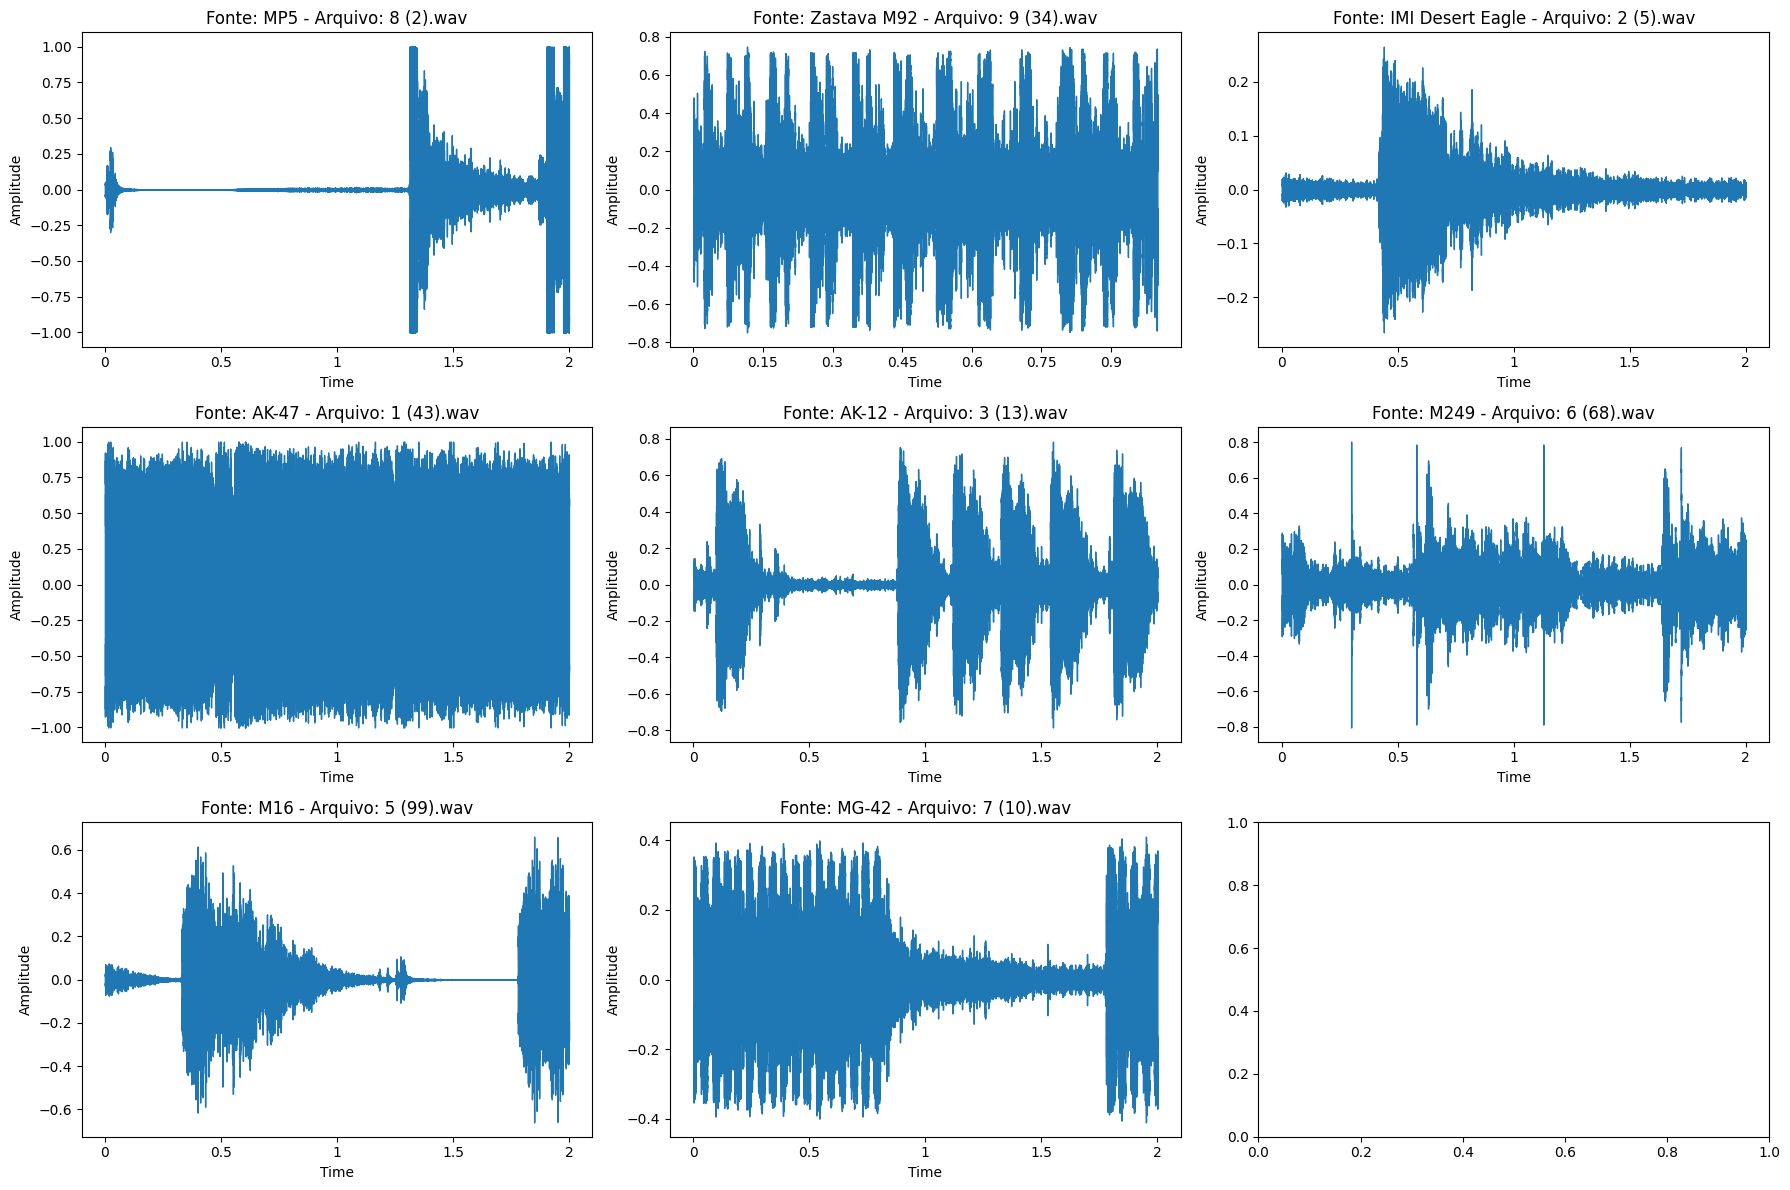

In [8]:
plot_amplitude_time(lista_exemplos)

## Análise de Domínio da Frequência (Magnitude x Frequência)

A decomposição por FFT (Fast Fourier Transform) nos permite observar o **espectro de potência** de cada disparo, revelando o "timbre" único de cada arma:

* **Conteúdo de Baixa Frequência (0 - 500 Hz):** Concentra a maior parte da energia de todos os áudios, correspondendo ao impacto acústico da deflagração (explosão).
* **Largura de Banda e Ruído:** Armas como a **AK-47** apresentam uma magnitude sustentada em frequências mais altas, o que caracteriza um som mais "áspero" e rico em harmônicos mecânicos. 
* **Decaimento Espectral:** Observamos que a energia decai rapidamente após os 10kHz na maioria das amostras, indicando que as características cruciais para a diferenciação das armas residem nos registros graves e médios.

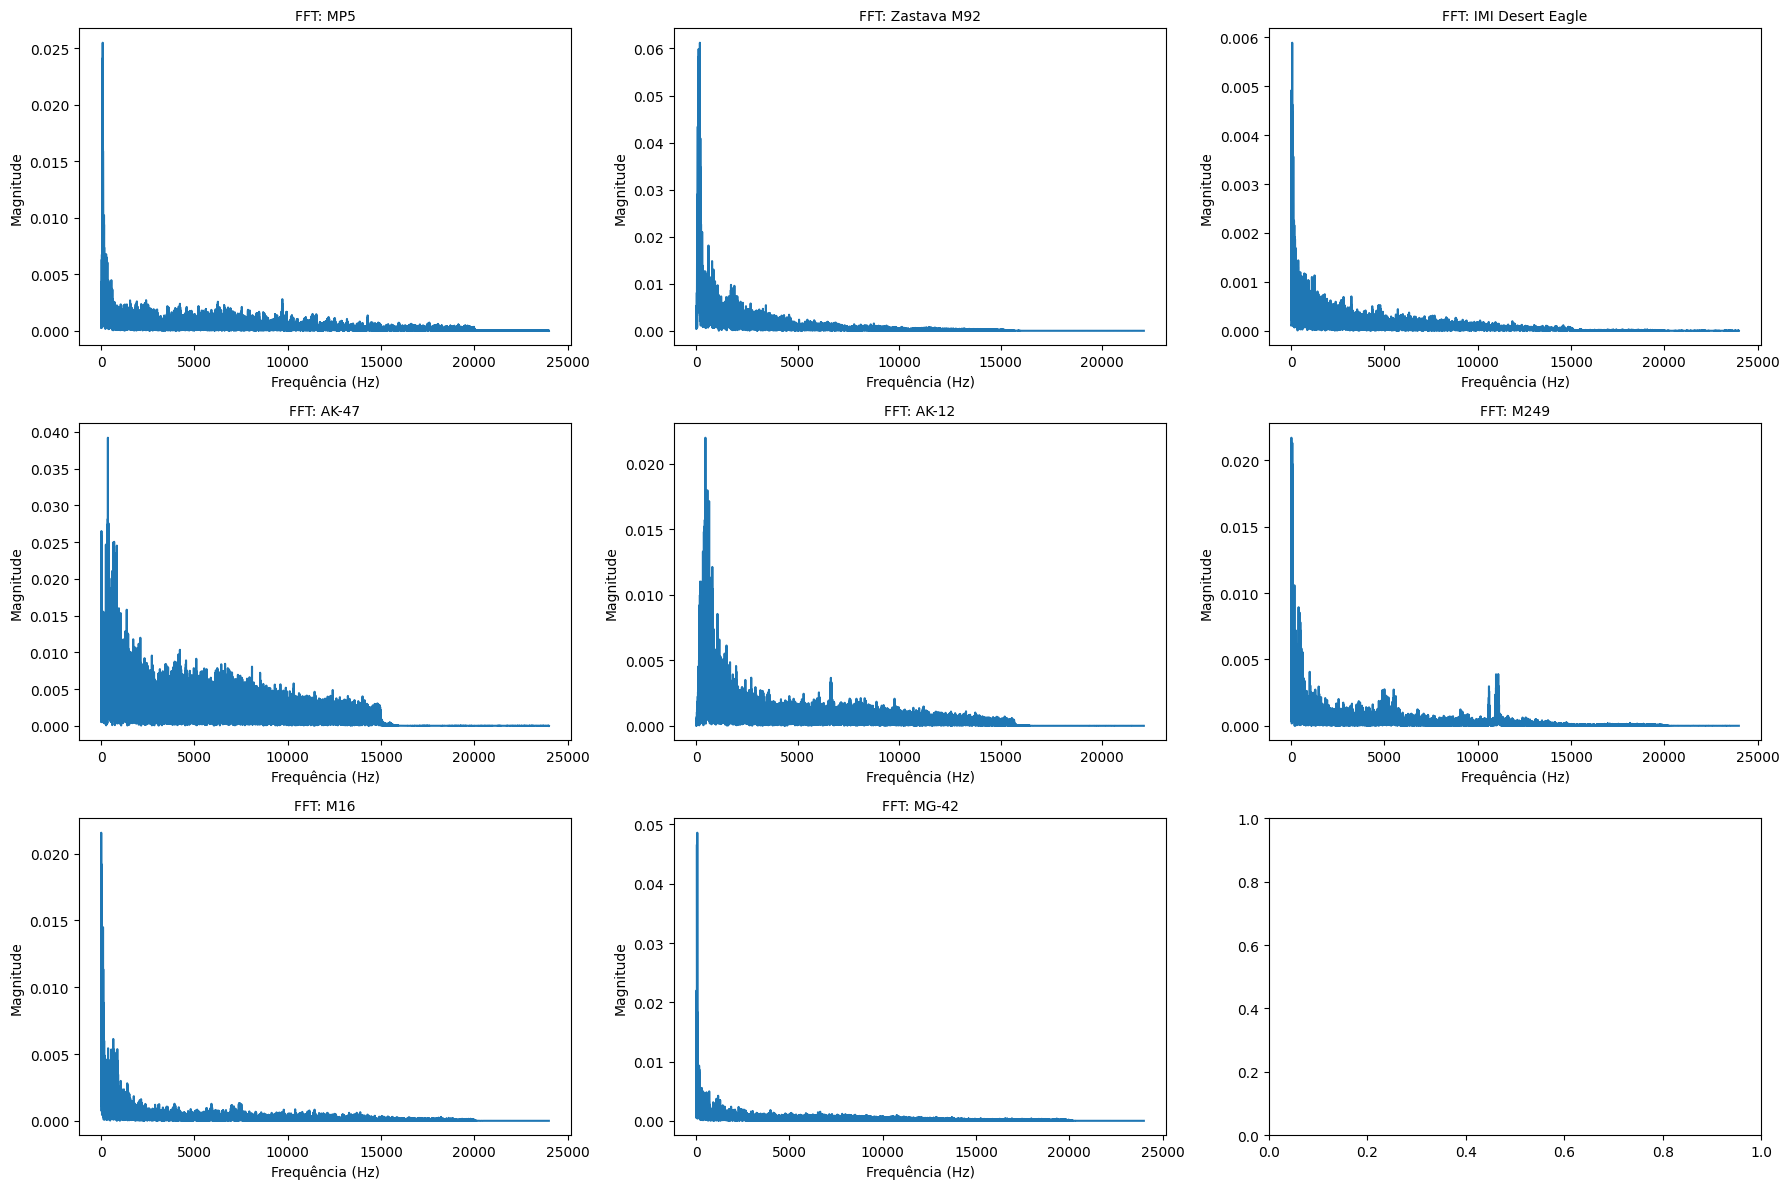

In [9]:
plot_fft_grid(lista_exemplos)

## Análise por Espectrograma (STFT)

O Espectrograma nos permite visualizar a energia sonora simultaneamente nos domínios do **tempo (eixo X)** e da **frequência (eixo Y)**. Para o dataset de armas, observamos:

* **Cadência de Tiro:** A densidade de linhas verticais revela o comportamento automático das armas. A **MG-42** exibe uma sucessão quase contínua de disparos, enquanto a **Desert Eagle** apresenta um evento impulsivo isolado de altíssima energia.
* **Componentes Espectrais:** O brilho intenso nas frequências baixas (0-2kHz) identifica a deflagração da munição. As frequências mais altas (acima de 5kHz) capturam o estalo metálico do projétil e o mecanismo de ejeção.
* **Decaimento Temporal:** É possível observar a assinatura da reverberação após cada disparo. Armas de maior calibre tendem a apresentar uma "mancha" de energia mais persistente nas frequências médias, indicando um som mais encorpado e duradouro.

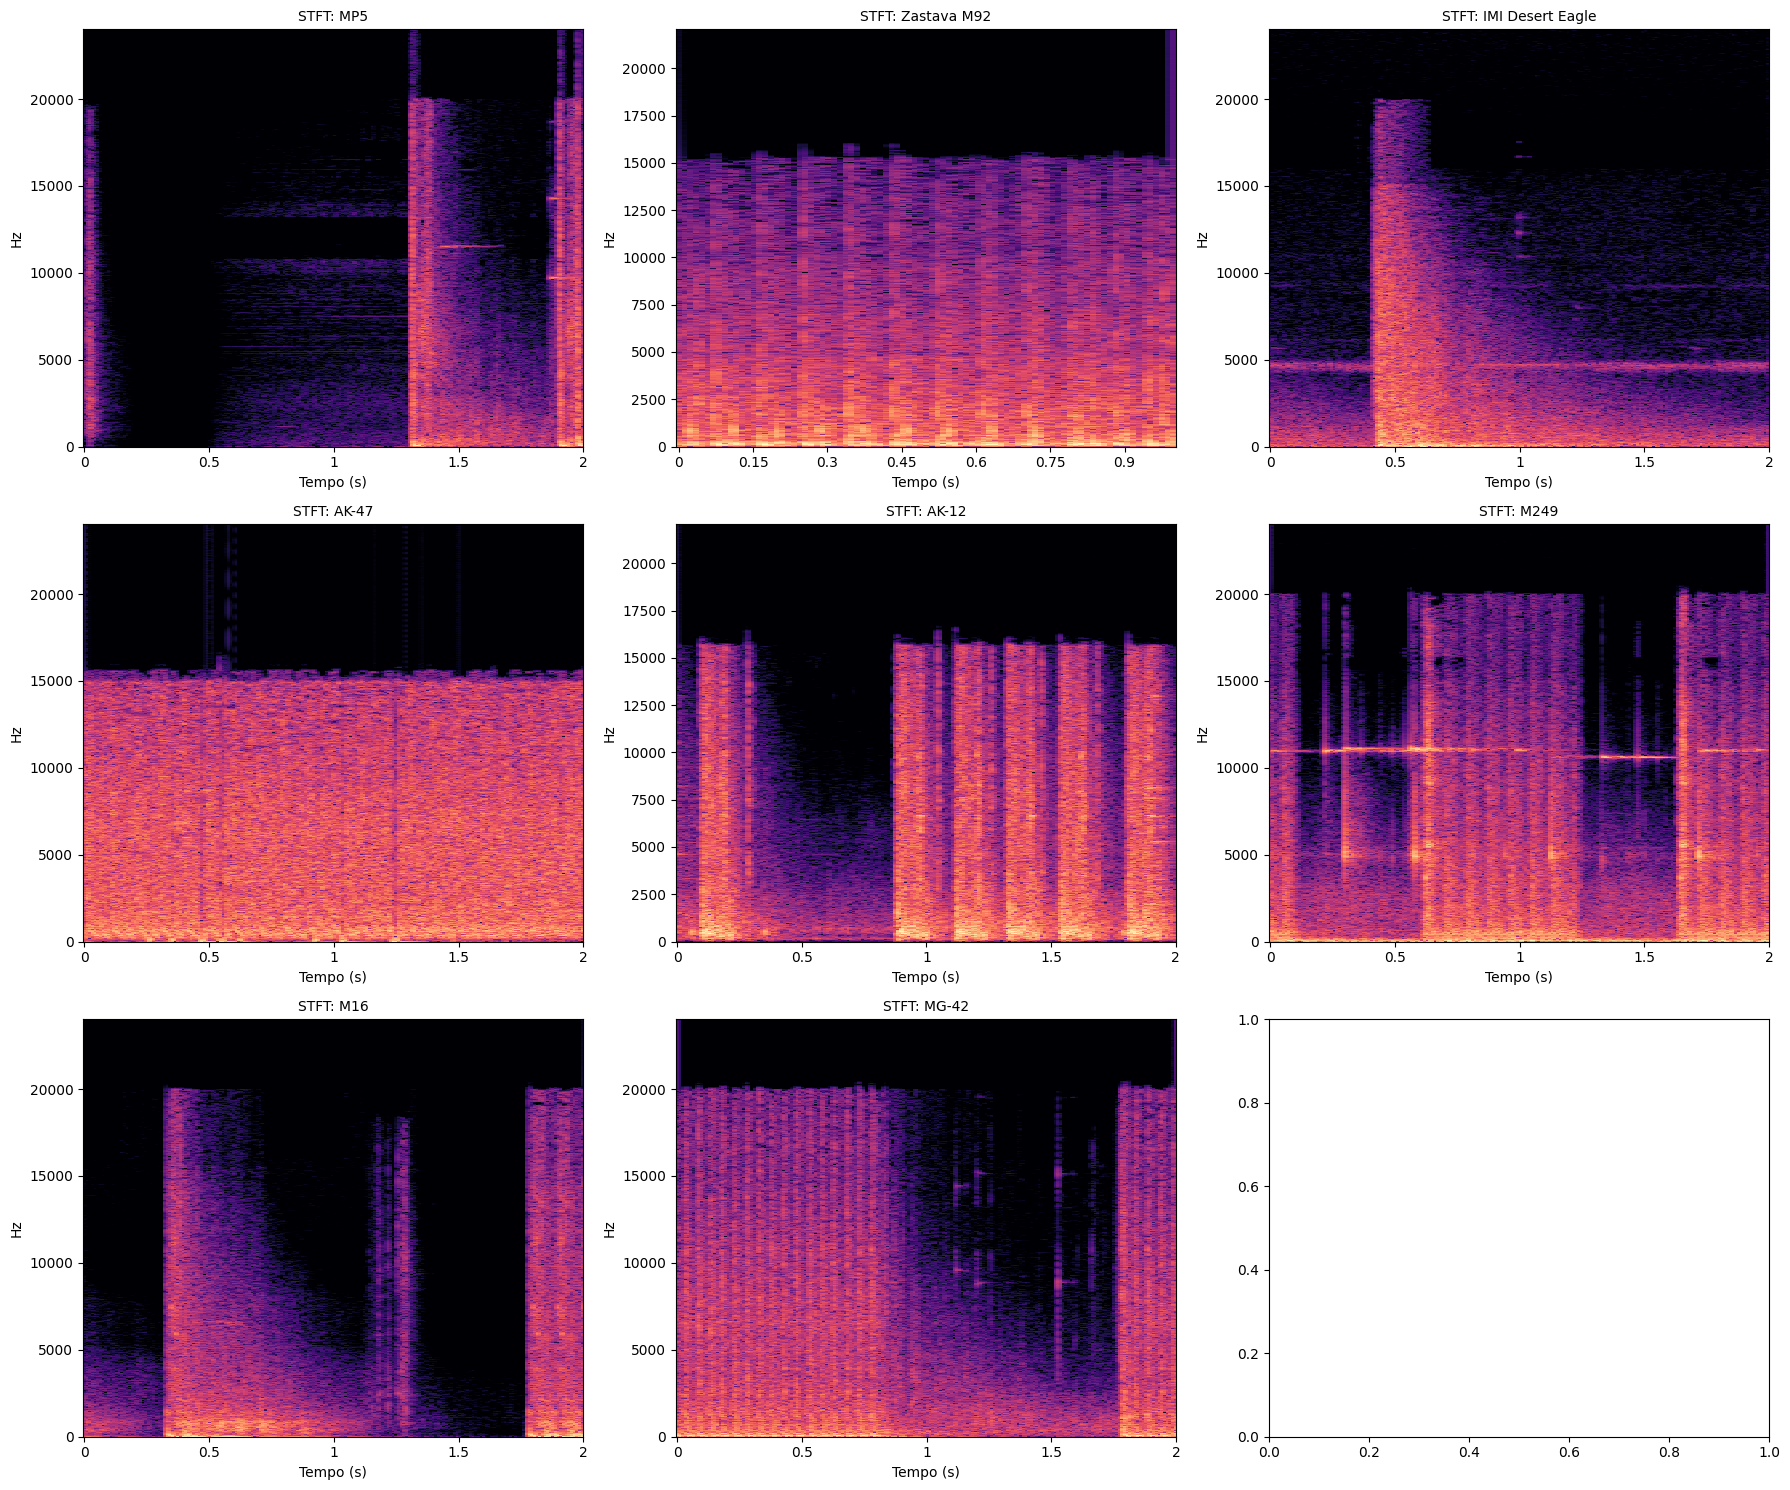

In [10]:
plot_stft_grid(lista_exemplos)

---
## Dataset e Pré-processamento (Mel-Espectrograma)

Nesta seção são apresentados os passos que transformam os arquivos de áudio brutos em tensores prontos para alimentar a CNN:
1. **Organização do DataFrame** com caminhos e rótulos de cada amostra.
2. **Divisão estratificada** em Treino (70%), Validação (15%) e Teste (15%).
3. **Pipeline de extração** dos Mel-espectrogramas.
4. **Montagem dos tensores** com shape e normalização adequados.

---

## Aprendizagem de Máquina e Preparação do Dataset

Embora o `librosa.load` converta o sinal sonoro em um array numérico ($y$), o uso de dados brutos (*raw audio*) apresenta desafios para modelos de Aprendizagem de Máquina. Com uma taxa de amostragem padrão de $22.050$ Hz, um único segundo de áudio gera um vetor de alta dimensionalidade, carregado de redundâncias e ruído ambiental.

Para otimizar o fluxo de treinamento, o primeiro passo é a **organização estrutural** dos arquivos.

### Mapeamento de Arquivos e Rótulos
A função abaixo automatiza a varredura do diretório base, associando cada arquivo à sua respectiva categoria (classe).

> **Por que utilizar um Dataframe?** > Centralizar os caminhos (*filepaths*) e rótulos (*labels*) em uma estrutura de dados do Pandas facilita a manipulação do dataset, permitindo auditorias rápidas, filtragens e, principalmente, uma **divisão estratificada** consistente entre os conjuntos de treino e teste.

In [11]:
def criar_dataframe_arquivos(diretorio_base):
    lista_arquivos = []

    for label in os.listdir(diretorio_base):
        path_classe = os.path.join(diretorio_base, label)
        
        # Verifica se é uma pasta
        if os.path.isdir(path_classe):
            
            # Agora percorre os arquivos de áudio dentro da pasta da arma
            for nome_arquivo in os.listdir(path_classe):
                # Filtra apenas arquivos de áudio (se houver lixo ou txt, ignora)
                if nome_arquivo.lower().endswith(('.wav', '.mp3')):
                    path_completo = os.path.join(path_classe, nome_arquivo)
                    
                    # Adiciona a lista
                    lista_arquivos.append({
                        'filepath': path_completo,
                        'label': label
                    })

    # Transforma a lista em DataFrame do Pandas
    df = pd.DataFrame(lista_arquivos)
    
    return df

In [12]:
df_audios = criar_dataframe_arquivos(path)


In [13]:
print(f"Quantidade de dados: {df_audios.value_counts('label').sum()}\n")
print(df_audios.value_counts('label'))

Quantidade de dados: 751

label
M16                 100
IMI Desert Eagle    100
MP5                 100
MG-42               100
M249                 99
AK-12                98
Zastava M92          82
AK-47                72
Name: count, dtype: int64


> **Balanceamento verificado:** A diferença máxima de 28 amostras entre as classes é inferior a 4% do total, o que não compromete o aprendizado. Não é necessário aplicar técnicas de balanceamento (ex.: oversampling) neste caso.

### Justificativa da divisão de dados

- Dividir os dados entre 70% Treino 15% Validação e 15% teste

A separação em treino, validação e teste é necessária para evitar avaliação enviesada.

- **Treino**: ajuste dos pesos da rede.
- **Validação**: seleção de hiperparâmetros e controle de overfitting.
- **Teste**: estimativa final de desempenho em dados não vistos.

O uso de `stratify` mantém a proporção das classes em todas as partições.
> **Por que `stratify=y`?** Garante que a proporção de cada classe seja mantida em todas as partições. Sem isso, por acaso, uma classe poderia ficar sub-representada no treino e inflacionar métricas de teste.

In [14]:
X = df_audios['filepath']  
y = df_audios['label']

In [15]:
X.shape, y.shape

((751,), (751,))

In [16]:
y

0        MP5
1        MP5
2        MP5
3        MP5
4        MP5
       ...  
746    MG-42
747    MG-42
748    MG-42
749    MG-42
750    MG-42
Name: label, Length: 751, dtype: object

In [17]:
X

0        data/MP5/8 (95).wav
1         data/MP5/8 (2).wav
2         data/MP5/8 (1).wav
3        data/MP5/8 (84).wav
4        data/MP5/8 (78).wav
               ...          
746    data/MG-42/7 (12).wav
747    data/MG-42/7 (93).wav
748    data/MG-42/7 (42).wav
749    data/MG-42/7 (27).wav
750    data/MG-42/7 (73).wav
Name: filepath, Length: 751, dtype: object

In [18]:
X_train_val,X_test, y_train_val, y_test = train_test_split(X,y,test_size=0.15, random_state=42, stratify=y)
X_train,X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.176, random_state=42,stratify=y_train_val)

In [19]:
print(f"Shape X_train: {X_train.shape}")
print(f"Tipo do dado: {type(X_train)}")

Shape X_train: (525,)
Tipo do dado: <class 'pandas.core.series.Series'>


#### Motivação: por que converter áudio em imagem?

Redes Neurais Convolucionais (CNNs) são excelentes para capturar padrões locais em imagens. O Mel-Espectrograma mapeia o sinal de áudio em uma representação 2D onde:
- **Eixo X** → tempo
- **Eixo Y** → frequência (escala Mel, perceptualmente motivada)
- **Intensidade do pixel** → energia em dB

Com isso, padrões acústicos distintos entre armas ficam visualmente separáveis, e a CNN pode aprendê-los como faria com qualquer imagem.

### Feature Engineering: Transformando Áudio em Visão

Diferente de redes neurais simples, as CNNs são excepcionais em detectar padrões espaciais. Ao transformar o som em imagem, a rede pode aprender a morfologia visual da "explosão" do tiro, identificando transientes e texturas que seriam difíceis de isolar no dado bruto.

### Padronização e Dimensionalidade

Uma restrição fundamental das CNNs é a exigência de **entradas com dimensões fixas**. Como o dataset é composto majoritariamente por áudios de 2 segundos, temos a base ideal para essa padronização.

#### Otimização da Taxa de Amostragem (Resampling)

Embora os arquivos originais possuam qualidade de estúdio ($f_s$ = 48.000 Hz), realizamos o *downsampling* para **22.050 Hz** pelos seguintes motivos:

* **Relevância Espectral:** A maioria das características distintivas de um tiro (graves da explosão e médios mecânicos) reside abaixo de 11 kHz. Pelo **Teorema de Nyquist**, uma taxa de 22 kHz é suficiente para capturar essas informações sem perdas significativas.
* **Eficiência Computacional:** Reduzir a taxa de 48k para 22k corta o volume de dados pela metade. Isso resulta em um treinamento até 2x mais rápido e menor consumo de memória VRAM na GPU.

---

### Resumo da Transformação de Dados

Ao configurar os parâmetros de extração, convertemos um vetor massivo em uma imagem compacta e rica em informação:

| Parâmetro | Valor Original (48k) | Valor Otimizado (22k) |
| --- | --- | --- |
| **Total de Amostras (2s)** | 96.000 pontos | 44.100 pontos |
| **Dimensão Final (Mel)** | - | **$128 \times 87$ pixels** |

> **Conclusão:** Saímos de um vetor unidimensional "pesado" de 96.000 pontos para uma matriz bidimensional de apenas 11.136 pixels ($128 \times 87$). Esta compressão inteligente preserva a "assinatura" do disparo enquanto remove redundâncias, tornando o aprendizado do modelo muito mais eficaz.



In [20]:
# --- 1. Configurações de Áudio e Imagem ---
SAMPLE_RATE = 22050
DURATION = 2.0   # Duração fixa de 2 segundos
N_MELS = 128     # Altura da imagem (eixo Y - frequências)
HOP_LENGTH = 512 # Passo da janela (afeta a largura da imagem)

# Número exato de amostras que precisamos (2 segundos * 22050 Hz)
SAMPLES_FIXOS = int(SAMPLE_RATE * DURATION)

Definição dos hiperparâmetros do Mel-espectrograma:

- **SAMPLE_RATE = 22050 Hz**: taxa de amostragem padrão para áudio.
- **DURATION = 2s**: todos os áudios são cortados ou preenchidos para ter exatamente 2 segundos.
- **n_mels = 128**: número de bandas de frequência — define a **altura** da imagem gerada.
- **HOP_LENGTH = 512**: passo da janela deslizante da STFT — define a **largura** da imagem. Quanto menor o valor, mais "largo" o espectrograma (mais resolução temporal).

Esses valores geram tensores de shape `(128, 87, 1)` por amostra — altura × largura × canal de cor.

A função de extração abaixo aplica três cuidados essenciais para a qualidade dos dados:

1. **Reamostragem e duração fixa** para padronizar todas as entradas.
2. **Conversão para escala log (dB)**, que aproxima melhor a percepção auditiva.
3. **Canal explícito** no final do tensor para compatibilidade com camadas convolucionais 2D.


Para aumentar a diversidade dos dados e reduzir overfitting, duas técnicas são aplicadas **exclusivamente no treino**:
- **Ruído gaussiano** (`add_noise`): simula variações de ambiente e microfone.
- **Deslocamento temporal** (`time_shift`): simula disparos que começam em momentos ligeiramente diferentes.

Validação e teste **não recebem aumento**, mantendo a avaliação representativa do mundo real.

In [21]:
def add_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    augmented_y = y + noise_factor * noise
    return augmented_y

def time_shift(y, shift_max=0.2):
    shift = np.random.randint(int(len(y) * shift_max))
    return np.roll(y, shift)

def extrair_features(file_path, augment= False, choice = None):
    try:
        # Carrega o áudio
        # res_type='kaiser_fast' agiliza o carregamento
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, res_type='kaiser_fast')

        if augment:
            if choice == "noise":
                y = add_noise(y)
            elif choice == "shift":
                y = time_shift(y)

        # Garante o tamanho exato (Padding ou Corte)
        # Mesmo que tenham 2s, isso previne erros de arredondamento
        if len(y) < SAMPLES_FIXOS:
            y = librosa.util.fix_length(y, size=SAMPLES_FIXOS)
        else:
            y = y[:SAMPLES_FIXOS]

        # Gera o Mel-Spectrogram
        melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH)
        
        # Converte para Decibéis (Log-Scale) -> Isso é o que "vemos" como imagem
        melspec_db = librosa.power_to_db(melspec, ref=np.max)

        # Adiciona a dimensão do canal (Necessário para CNNs: Altura, Largura, Canais)
        # Resultado final será algo como (128, 87, 1)
        melspec_db = melspec_db[..., np.newaxis]
        
        return melspec_db

    except Exception as e:
        print(f"Erro no arquivo {file_path}: {e}")
        return None



> **Exemplo visual:** O espectrograma abaixo ilustra como cada amostra de áudio é convertida para a 'imagem' que a CNN irá processar. Regiões mais claras indicam maior energia naquela faixa de frequência e instante de tempo.

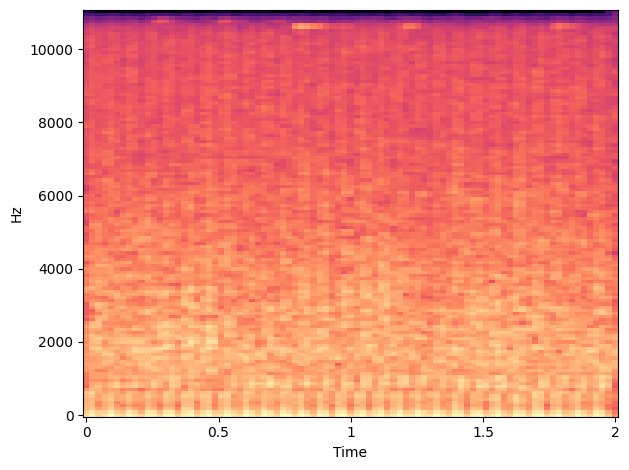

In [22]:
# Exemplo de imagem que vai pra CNN
plot = plt.plot(figsize=(20,20))
file_path = "./data/M249/6 (12).wav"

y, sr = librosa.load(file_path, sr=SAMPLE_RATE, res_type='kaiser_fast')

melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH)
        
# Converte para Decibéis (Log-Scale) -> Isso é o que "vemos" como imagem
melspec_db = librosa.power_to_db(melspec, ref=np.max)

img = librosa.display.specshow(melspec_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma')

plt.tight_layout()
plt.show()

### Montagem dos tensores de treino, validação e teste

A seguir, os mel-espectrogramas são gerados para cada partição e organizados em arrays NumPy com shape consistente para a CNN.

No treino, o dataset é expandido com versões aumentadas (ruído e deslocamento temporal), enquanto validação e teste permanecem sem aumento para medir desempenho realista.

In [23]:
# --- 1. GERAÇÃO DOS DADOS DE TREINO (Aumentados) ---
print("Gerando espectrogramas de TREINO (Originais)...")
X_train_orig = [extrair_features(f, augment=False) for f in tqdm(X_train)]

print("Gerando espectrogramas de TREINO (Com Ruído)...")
X_train_noise = [extrair_features(f, augment=True, choice="noise") for f in tqdm(X_train)]

print("Gerando espectrogramas de TREINO (Com Shift)...")
X_train_shift = [extrair_features(f, augment=True, choice="shift") for f in tqdm(X_train)]

# Concatena as listas e converte para Array Numpy
X_train_final = np.array(X_train_orig + X_train_noise + X_train_shift)

# --- 2. GERAÇÃO DOS DADOS DE VALIDAÇÃO E TESTE (Originais) ---
print("Gerando espectrogramas de VALIDAÇÃO...")
X_val_final = np.array([extrair_features(f) for f in tqdm(X_val)])

print("Gerando espectrogramas de TESTE...")
X_test_final = np.array([extrair_features(f) for f in tqdm(X_test)])

# --- 3. TRATAMENTO DOS RÓTULOS (Labels) ---
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train) # Labels originais numéricos

# REPETIR os rótulos 3 vezes para alinhar com o X_train_final (Original + Noise + Shift)
y_train_final = np.concatenate([y_train_encoded, y_train_encoded, y_train_encoded])

y_val_num = le.transform(y_val)
y_test_num = le.transform(y_test)

# --- 4. SHUFFLE ---
# Embaralha X e y simultaneamente para misturar originais e aumentados
X_train_final, y_train_final = shuffle(X_train_final, y_train_final, random_state=42)

print("-" * 30)
print(f"Treino: {X_train_final.shape} | Labels: {y_train_final.shape}")
print(f"Validação: {X_val_final.shape} | Labels: {y_val_num.shape}")
print("-" * 30)

Gerando espectrogramas de TREINO (Originais)...


100%|██████████| 525/525 [00:14<00:00, 35.96it/s]


Gerando espectrogramas de TREINO (Com Ruído)...


100%|██████████| 525/525 [00:13<00:00, 37.88it/s]


Gerando espectrogramas de TREINO (Com Shift)...


100%|██████████| 525/525 [00:15<00:00, 34.73it/s]


Gerando espectrogramas de VALIDAÇÃO...


100%|██████████| 113/113 [00:04<00:00, 23.27it/s]


Gerando espectrogramas de TESTE...


100%|██████████| 113/113 [00:04<00:00, 23.17it/s]

------------------------------
Treino: (1575, 128, 87, 1) | Labels: (1575,)
Validação: (113, 128, 87, 1) | Labels: (113,)
------------------------------


In [24]:

# --- 4. Verificação Final ---
print("\n--- Relatório de Formatos ---")
print(f"Shape Input Treino (X): {X_train_final.shape}")
print(f"Shape Input Val (X):    {X_val_final.shape}")
print(f"Shape Input Teste (X):  {X_test_final.shape}")
print(f"\nExemplo de Rótulos convertidos: {y_train_final[:5]}")
print(f"Classes identificadas: {le.classes_}")


--- Relatório de Formatos ---
Shape Input Treino (X): (1575, 128, 87, 1)
Shape Input Val (X):    (113, 128, 87, 1)
Shape Input Teste (X):  (113, 128, 87, 1)

Exemplo de Rótulos convertidos: [7 6 1 2 7]
Classes identificadas: ['AK-12' 'AK-47' 'IMI Desert Eagle' 'M16' 'M249' 'MG-42' 'MP5'
 'Zastava M92']


Nesta etapa, os dados já estão em formato numérico e padronizado para entrada da rede. O próximo passo é definir a arquitetura da CNN, compilar o modelo e treinar com validação para acompanhar generalização.

## Implementação da Rede Neural

Observar a versão do TensorFlow e listar os dispositivos

In [25]:
print("Versão do TensorFlow:", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Sucesso! GPU detectada: {gpus[0]}")
else:
    print("Aviso: Nenhuma GPU detectada. O TensorFlow rodará apenas na CPU.")

Versão do TensorFlow: 2.20.0
Sucesso! GPU detectada: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Definição da arquitetura da Rede:

### Por que usar CNN para mel-espectrograma?

Ao converter o áudio, que é um sinal 1D(amplitude x tempo) em mel-espectrograma(ou STFT), o problema passa a ser semelhante a reconhecimento de padrões em imagem, já que agora temos uma representação 2D(tempo x frequência). A CNN consegue aprender estruturas locais relevantes (picos de energia, transientes, distribuição temporal de frequências e estruturas harmônicas), que são fundamentais para caracterizar o timbre e o comportamento de cada disparo, além de possuir uma melhor distribuição dos pesos, já que os mesmos pesos são aplicados por toda a imagem, detectando padrões independente de sua posição na imagem. A CNN possui também invariância a pequenas variações, tanto de frequência quanto pequenos deslocamentos no tempo.

Para o nosso problema, foi escolhida a conversão para mel-espectrograma, tendo em vista que a escala mel se aproxima bastante da percepção auditiva humana, sendo melhor para generalização e em arquiteturas CNNs 2D, além de ser muito utilizada em problemas como reconhecimento de fala, classificação de sons ambiente, etc.

In [26]:

INPUT_SHAPE = (128, 87, 1) # Altura, Largura, Canais
NUM_CLASSES = 9            # Número de armas que temos

### Arquitetura CNN

A arquitetura foi organizada em 3 blocos convolucionais seguidos por um classificador. Cada bloco contém Conv2D, responsável pela extração de padrões do espectrograma, MaxPooling2D, que reduz a dimensão e aumenta a robustez da rede e BatchNormalization, que estabiliza e acelera o treinamento. Os filtros da rede aumentam progressivamente, permitindo que ela aprenda características mais complexas com o passar do tempo. Na classificação temos o GlobalAveragePooling2D, que reduz os mapas de ativação sem gerar muitos parâmetros, Dense + ReLU, que aprende combinações mais abstratas das features, L2(regularizador), responsável por previnir o overfitting, Dropout, que desativa alguns neurônios durante o treino para melhorar a generalização e Dense + Softmax, que vai gerar a probabilidade de cada classe.

### Otimização

#### Early Stopping

O early stopping monitora a perda na etapa de validação, se após 15 épocas não houver melhora ele restaura os melhores pesos. Ajuda a evitar overfitting e treinamentos desnecessários.

#### ReduceLROnPlateau

Permite ajustes finos quando o modelo passar 5 epócas sem melhora, reduzindo a taxa de aprendizado.

#### ModelCheckpoint

Garante a preservação do melhor modelo, salvando aquele com melhor acurácia.

In [27]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    min_delta=0.001,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,   # Reduz a LR em 5x
    patience=5,   # Se em 5 épocas não melhorar, reduz
    min_lr=0.00001,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'modelo_classificacao_armas.keras', 
    monitor='val_accuracy', 
    save_best_only=True, 
    verbose=1
)

model = Sequential([
    # Bloco 1
    Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=INPUT_SHAPE),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Bloco 2
    Conv2D(64, (3, 3), activation='relu',padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Bloco 3
    Conv2D(128, (3, 3), activation='relu',padding='same',),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Classificador
    GlobalAveragePooling2D(),
    Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax') # Saída (Probabilidade de cada arma)
])

/home/orlandojunior/miniconda3/envs/percepcao/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1772200345.180077    2597 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9702 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [28]:
# Compila o modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # 'sparse' pois os labels são inteiros (0, 1, 2...)
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 87, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 43, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,241 (434.54 KB)

 Trainable params: 110,793 (432.79 KB)

 Non-trainable params: 448 (1.75 KB)

### Estratégia de treinamento

Aqui o modelo é treinado usando os conjuntos de treino e validação. O processo utiliza:

- **EarlyStopping** para interromper quando não há ganho relevante.
- **ReduceLROnPlateau** para reduzir a taxa de aprendizado em platôs.
- **ModelCheckpoint** para salvar automaticamente os melhores pesos.

Essa combinação ajuda a reduzir overfitting e melhora a estabilidade do treinamento.

In [29]:
# --- 2. Treinamento ---
print("\nIniciando treinamento...")
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_num),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr,checkpoint]
)


Iniciando treinamento...
Epoch 1/100


2026-02-27 10:52:27.536979: I external/local_xla/xla/service/service.cc:163] XLA service 0x7097c0023620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-27 10:52:27.537002: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2026-02-27 10:52:27.617182: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-27 10:52:27.913648: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91801
2026-02-27 10:52:28.030948: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-27 10:52:28.031582: I e

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3282 - loss: 3.1822

I0000 00:00:1772200352.517279   34792 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3822 - loss: 2.9239

2026-02-27 10:52:36.700148: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-27 10:52:37.198152: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_158', 28 bytes spill stores, 28 bytes spill loads

2026-02-27 10:52:37.241544: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_158', 28 bytes spill stores, 28 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.10619, saving model to modelo_classificacao_armas.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.3833 - loss: 2.9185 - val_accuracy: 0.1062 - val_loss: 6.9464 - learning_rate: 0.0010
Epoch 2/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5522 - loss: 2.0990
Epoch 2: val_accuracy improved from 0.10619 to 0.30088, saving model to modelo_classificacao_armas.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5534 - loss: 2.0949 - val_accuracy: 0.3009 - val_loss: 2.6449 - learning_rate: 0.0010
Epoch 3/100
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6157 - loss: 1.7169
Epoch 3: val_accuracy improved from 0.30088 to 0.32743, saving model to modelo_classificacao_armas.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6175 - loss: 1.7109 - val_accuracy: 0.3274 - val_loss: 2.5941 - learning_rate: 0.0010
Epoch 4/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6686 - loss: 1.4305
Epoch 4: 

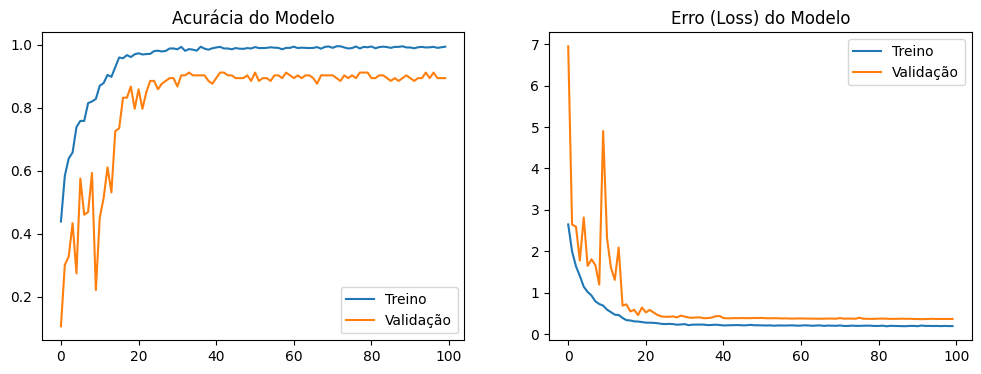

In [30]:
plt.figure(figsize=(12, 4))

# Gráfico de Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia do Modelo')
plt.legend()

# Gráfico de Perda (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Erro (Loss) do Modelo')
plt.legend()

plt.show()

### Análise das Curvas de Treinamento

#### Acurácia

A acurácia de treino cresce de forma estável até aproximadamente 95%.

A acurácia de validação também cresce, mas com variações, estabilizando em torno de 90%.

O modelo aprende padrões relevantes, porém ainda existe um leve overfitting, que pode ser explicado pelo tamanho da base de dados, que não foi ideal.

#### Loss/Perda

A perda de treino diminui continuamente.

A perda de validação apresenta variações no início, mas depois estabiliza.

### O que será avaliado nesta etapa

A avaliação será feita com três visões complementares:

- **Acurácia global** no conjunto de teste.
- **Relatório por classe** (precision, recall e f1-score) para entender desempenho específico de cada arma.
- **Matriz de confusão** para identificar padrões de erro e classes que se sobrepõem acusticamente.

## Análise de Métricas

In [31]:
y_pred_probs = model.predict(X_test_final)

# 2. Pegar o índice da maior probabilidade (A classe vencedora)
# Ex: Se a posição 1 tem 0.8, então a classe predita é 1
y_pred_classes = np.argmax(y_pred_probs, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


In [32]:
# Recupera os nomes das classes originais do seu LabelEncoder
nomes_classes = le.classes_

print("--- Relatório de Classificação ---\n")
print(classification_report(y_test_num, y_pred_classes, target_names=nomes_classes))

--- Relatório de Classificação ---

                  precision    recall  f1-score   support

           AK-12       1.00      1.00      1.00        15
           AK-47       1.00      1.00      1.00        11
IMI Desert Eagle       0.83      1.00      0.91        15
             M16       0.79      0.73      0.76        15
            M249       0.93      0.87      0.90        15
           MG-42       1.00      1.00      1.00        15
             MP5       0.86      0.80      0.83        15
     Zastava M92       1.00      1.00      1.00        12

        accuracy                           0.92       113
       macro avg       0.93      0.93      0.92       113
    weighted avg       0.92      0.92      0.92       113



## Interpretação do relatório de classificação

### Visão geral
- O modelo atingiu **acurácia de 0.92** em **113 amostras**, o que indica um ótimo desempenho, com destaque para classes como **AK-12, AK-47, MG-42 e ZASTAVA M92**, que tiveram 1.00, tanto de precision quanto de recall e f1-score.


- As médias **macro** (0.93) e **weighted** (0.92) estão próximas, sugerindo que o desempenho está equilibrado entre as classes, ou seja, não existe algumas muito boas e outras muito distantes.

### Conclusão

O modelo tem **resultados excelentes** para as classes treinadas, o que comprova que, para este cenário, que o método abordado de utilizar mel-espectogramas para treinamento sonoro pode ser boa escolha.

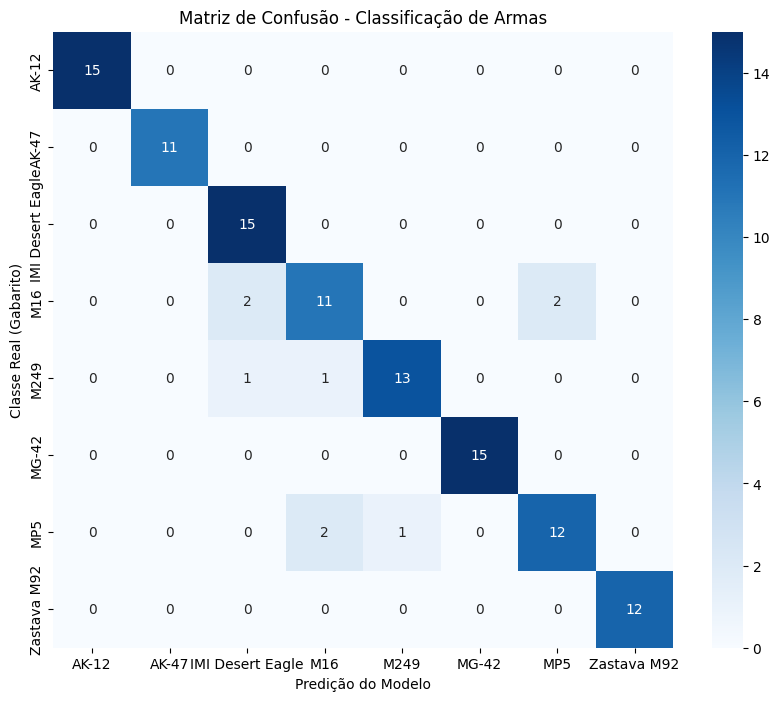

In [17]:
# Gera a matriz matemática
cm = confusion_matrix(y_test_num, y_pred_classes)

# Plota usando Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=nomes_classes,
            yticklabels=nomes_classes)

plt.xlabel('Predição do Modelo')
plt.ylabel('Classe Real (Gabarito)')
plt.title('Matriz de Confusão - Classificação de Armas')
plt.show()

### Leitura da matriz de confusão

A diagonal principal representa os acertos por classe. Já os valores fora da diagonal mostram onde o modelo mais se confunde.

Neste trabalho, a diagonal principal mostra uma ótima acertividade do modelo (azul mais escuro), o que comprova as métricas anteriormente exibidas, e o ótimo desempenho do treinamento realizado.

## Conclusão

Recaptulando o que já foi mencionado, para esse experimento, foi construída uma pipeline completa de classificação de áudio de disparos de armas de fogo, contendo:

- Organização do dataset, para a estruturação dos arquivos e criação do DataFrame;
- Exploração inicial dos sinais, para entender se o dataset estava balanceado, e a maneira de lidar com ele;
- Transformação para mel-espectrogramas, explica a conversão de áudio em representações visuais 2D;
- Aumento de dados no treino, para maior diversidade nos dados de treinamento;
- Treinamento de uma CNN, apresentação da implementação e o processo de treinamento da rede;
- Avaliação dos resultados, finalização com as as métricas e análises utilizadas

Esses resultados nos mostraram que a abordagem com CNN sobre mel-espectrogramas é viável e consegue separar bem suas classes.

# Resultados antes da manipulação M4 x M16

**Antes:**

- Accuracy Total: 0.77
- Precision M4: 0.31
- Precision M16: 0.21

**Depois:**

- Accuracy Total: 0.92
- Precision M4: X
- Precision M16: 0.79

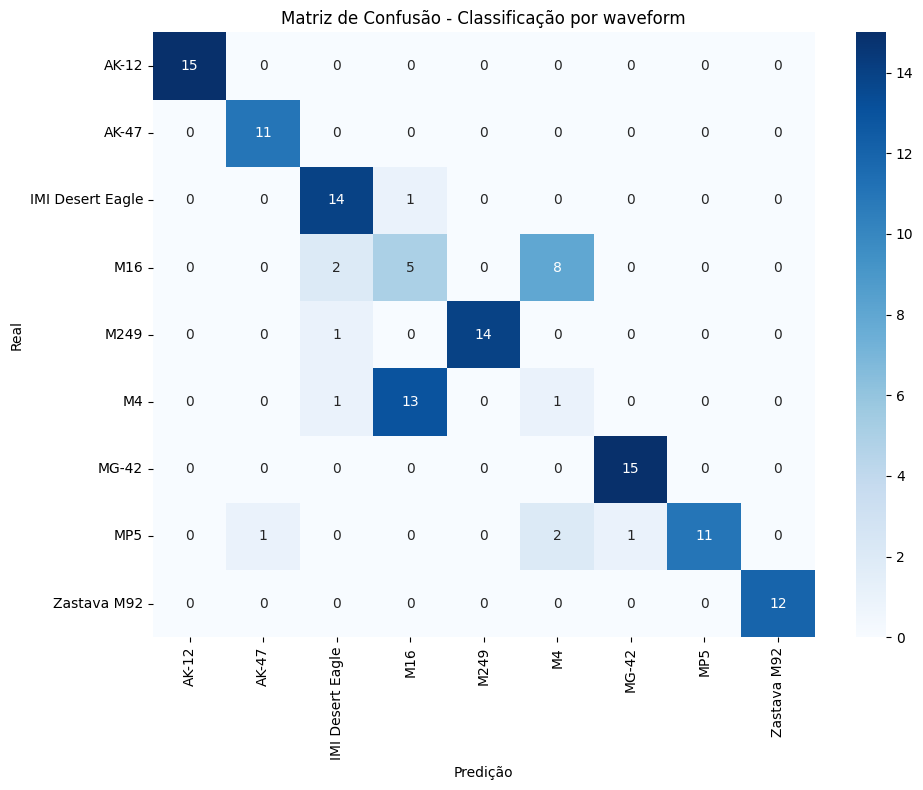

In [15]:
img = Image.open('matriz_antiga.png')
display(img)
